# Clusterización

 Utilizando el set de datos que hayas utilizado en las prácticas anteriores, aplica el modelo K-Means para realizar una agrupación de la data, posteriormente realiza análisis sobre los resultados y presenta los mismos en un reporte que contenga: Objetivo, técnica de aprendizaje, código, gráficas e interpretación de resultados. 

- Elige Set de Datos (Opiniones)

In [31]:
import pandas as pd
# Cargar el archivo Excel
file_path = 'corpus/Rest_Mex_2022_Sentiment_Analysis_Track_Train.xlsx'
df = pd.read_excel(file_path)
df.head()

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1,Hotel
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1,Hotel
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1,Hotel


**Preprocesa el set de datos: Aplicación de técnicas de Normalización (minúsculas, tokenización, eliminación de stopwords)**
- Funcion para preprocesamiento del texto

In [32]:
# Bibliotecas para procesamiento de texto
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Eliminamos valores nulos
df = df.dropna()
# Lematizador
lemmatizer = WordNetLemmatizer()
# Stopwords en español
stop_words = set(stopwords.words('spanish'))
# Creamos lista de tags a utilizar
tags = ['ADJ', 'NOUN', 'VERB', 'PROPN']
# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

def normalize_text(text):
    # Tokenizar el texto
    tokens = word_tokenize(text)

    # Convertir a minúsculas
    tokens_lower = [word.lower() for word in tokens]

    # Eliminar puntuación
    tokens_no_punct = [word for word in tokens_lower if word.isalnum()]

    # Eliminar stopwords
    tokens_no_stopwords = [word for word in tokens_no_punct if word not in stop_words]

    # Unir tokens
    tokens = " ".join(tokens_no_stopwords)

    # Procesar texto con spaCy
    doc = nlp(tokens)

    # Discriminar por tags
    normalized_text = [word.lemma_ for word in doc if word.pos_ in tags]
    
    # Unir en una sola cadena
    normalized_text = " ".join(normalized_text)

    return normalized_text

#sample_sentence = "¡Hola, Juan! ¿Cómo estás? Él está viajando en un avión a París. ¡Qué emocionante! #vacaciones"
#normalize_text(sample_sentence)


- Preprocesamiento del texto en paralelo

In [33]:
from concurrent.futures import ThreadPoolExecutor

def parallel_processing_threads(data, func):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(func, data))
    return results

# Normaliza el dataframe en paralelo
df['Opinion'] = parallel_processing_threads(df['Opinion'], normalize_text)

# Mostrar el dataframe
df.head()

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,pensar vez ir hotel molestar hijo año traer in...,1,Hotel
1,No vayas a lugar de Eddie,eddie placir servicio terrible pesar hecho edd...,1,Restaurant
2,Mala relación calidad-precio,seguir corta simple limpieza bad insistir limp...,1,Hotel
3,Minusválido? ¡No te alojes aquí!,reservar hotel multipropiedad mayan grupo deci...,1,Hotel
4,Es una porqueria no pierdan su tiempo,perder tiempo dinero venir boda complejo grand...,1,Hotel


**Vectoriza el dataset con Red Neuronal Doc2Vec**

In [34]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Preparar los datos
tagged_data = [TaggedDocument(words=opinion.split(), tags=[str(i)]) for i, opinion in enumerate(df['Opinion'])]

# Construir y entrenar el modelo
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Guardar el modelo para uso futuro
model.save("doc2vec_model_cluster")

**Determina el número recomendado de clústers**

c:\Users\Ali\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ali\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ali\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ali\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

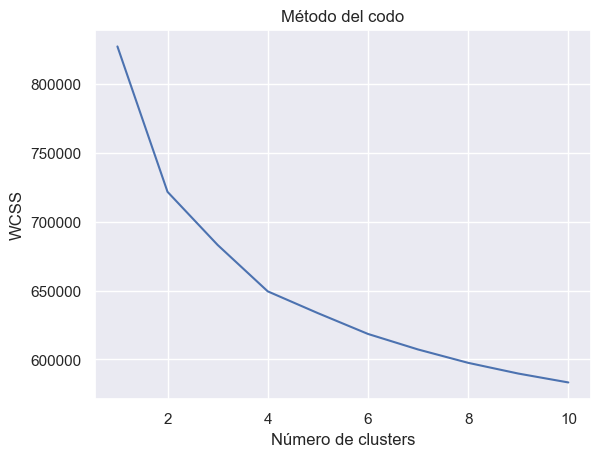

In [35]:
# Determinar numero de clusters recomendado por el metodo del codo
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el modelo
# model = Doc2Vec.load("doc2vec_model_cluster")

# Preparar los datos
X = np.array([model.infer_vector(opinion.split()) for opinion in df['Opinion']])

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Visualizar el método del codo
sns.set()
plt.plot(range(1, 11), wcss)
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()


**Divide tu set en Entrenamiento y Testing**

In [42]:
# Dividir el dataset en entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Preparar los datos
y = df['Polarity']

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Entrena el modelo K-means**